In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
string.punctuation
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk import sent_tokenize 
from nltk import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# machine learning models
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/FakeNews/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/FakeNews/True.csv')
#create new columns 'class' to store column target
fake['class'] = 0 
real['class'] = 1 

In [4]:
df = pd.concat([fake, real], axis=0)
df.head(5)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Simple EDA

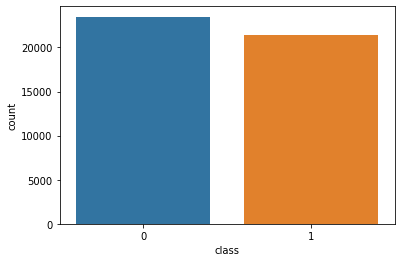

In [ ]:
sns.countplot(df['class'])

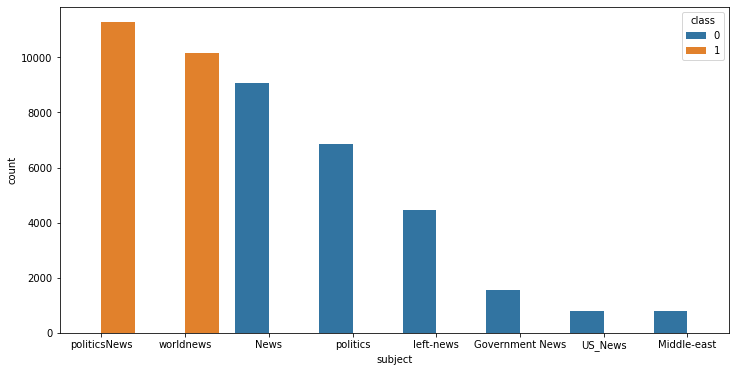

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='subject', hue='class', order = df['subject'].value_counts().index)
#plt.xticks(rotation=90)

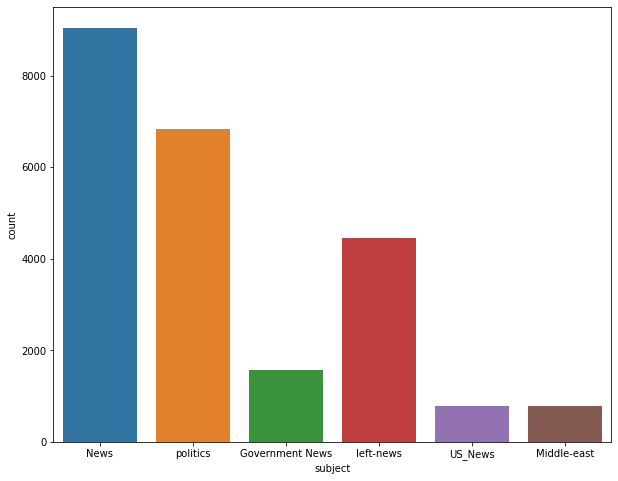

In [ ]:
df_fake = df.loc[df['class']==0]
df_real = df.loc[df['class']==1]

plt.figure(figsize=(10,8))
sns.countplot(df_fake['subject'])

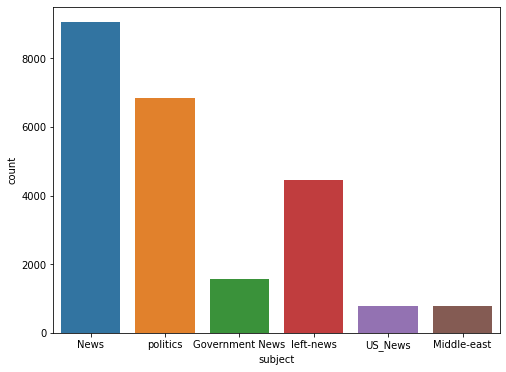

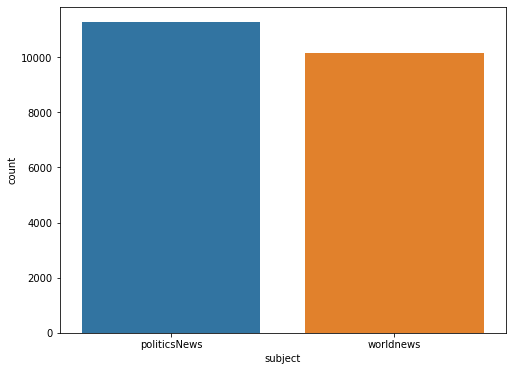

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df_fake['subject'])
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(df_real['subject'])
plt.show()

# Preprocess (cleantext)

In [5]:
df = df.drop(['subject', 'date'], axis=1) #drop columns subject and date  
df['combine']= df['title'] + " " + df['text'] #combine columns title and text
df = df.drop(['title','text'], axis=1) #drop title and text columns
df = df.reindex(columns=['combine','class']) #reorder index
df.head()

,combine,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [6]:
#remove punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [7]:
#string manipulation to clean the texts
def cleaning(df): 
    #lowercase the text
    df['clean'] = df['combine'].apply(lambda x: x.lower())
    #getting rid of whitespaces
    df['clean'] = df['clean'].apply(lambda x: x.replace('\n', ' '))
    #remove links
    df['clean'] = df['clean'].str.replace('http\S+|www.\S+', '', case=False)
    #removing '>'
    df['clean'] = df['clean'].apply(lambda x: x.replace('&gt;', ''))
    #removing '<'
    df['clean'] = df['clean'].apply(lambda x: x.replace('&lt;', ''))
    #remove punctuation
    df['clean'] = df['clean'].apply(remove_punctuations)
    #remove ' s ' that was created after removing punctuations
    df['clean'] = df['clean'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [8]:
df = cleaning(df)

In [9]:
df.clean.head(7)

0     donald trump sends out embarrassing new year ...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama name c...
4     pope francis just called out donald trump dur...
5     racist alabama cops brutalize black boy while...
6     fresh off the golf course  trump lashes out a...
Name: clean, dtype: object

Lemmatization using NLTK WordNet

In [10]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  temp = []
  for word in text.split():
    word = lemmatizer.lemmatize(word)
    temp.append(word)

  return ' '.join(temp)

In [11]:
df['lemmatized'] = df['clean'].apply(lambda x: lemmatize(x))
#After lemmatization, some pronouns are changed to '-PRON' and we're going to remove it
df['lemmatized'] = df['lemmatized'].apply(lambda x: x.replace('-PRON-', ' '))

Tokenization

In [12]:
df['tokenized_clean'] = df['lemmatized'].apply(word_tokenize)

Removing Stop Words

In [13]:
from collections import Counter
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)
df['tokenized_clean'] = df['tokenized_clean'].apply(lambda text_list: [x for x in text_list if x not in stopwords_dict])

In [14]:
#This one takes too long to process
#from nltk.corpus import stopwords
#my_stopwords = set(stopwords.words('english'))
#df['tokenized_clean'] = df['tokenized_clean'].apply(lambda text_list: [x for x in text_list if x not in stopwords.words('english')])

Removing Numbers

In [15]:
df['tokenized_clean'] = df['tokenized_clean'].apply(lambda list_data: [x for x in list_data if x.isalpha()])

In [16]:
df.tokenized_clean.head(7)

0    [donald, trump, sends, embarrassing, new, year...
1    [drunk, bragging, trump, staffer, started, rus...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsessed, even, ha, obama, name, coded...
4    [pope, francis, called, donald, trump, christm...
5    [racist, alabama, cop, brutalize, black, boy, ...
6    [fresh, golf, course, trump, lash, fbi, deputy...
Name: tokenized_clean, dtype: object

In [17]:
finale = list()
for list_of_words in df.tokenized_clean:
  finale.append(' '.join(list_of_words))

df['final_text'] = finale 

In [80]:
df.head(7)

,combine,class,clean,lemmatized,tokenized_clean,final_text
0,Donald Trump Sends Out Embarrassing New Year’...,0,donald trump sends out embarrassing new year ...,donald trump sends out embarrassing new year e...,"[donald, trump, sends, embarrassing, new, year...",donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,0,drunk bragging trump staffer started russian ...,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...",drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,0,sheriff david clarke becomes an internet joke...,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, internet, jo...",sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,trump is so obsessed he even has obama name c...,trump is so obsessed he even ha obama name cod...,"[trump, obsessed, even, ha, obama, name, coded...",trump obsessed even ha obama name coded websit...
4,Pope Francis Just Called Out Donald Trump Dur...,0,pope francis just called out donald trump dur...,pope francis just called out donald trump duri...,"[pope, francis, called, donald, trump, christm...",pope francis called donald trump christmas spe...
5,Racist Alabama Cops Brutalize Black Boy While...,0,racist alabama cops brutalize black boy while...,racist alabama cop brutalize black boy while h...,"[racist, alabama, cop, brutalize, black, boy, ...",racist alabama cop brutalize black boy handcuf...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",0,fresh off the golf course trump lashes out a...,fresh off the golf course trump lash out at fb...,"[fresh, golf, course, trump, lash, fbi, deputy...",fresh golf course trump lash fbi deputy direct...


In [75]:
from wordcloud import WordCloud

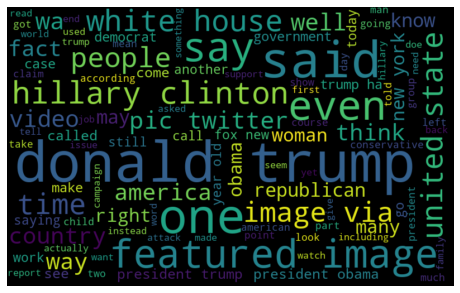

In [81]:
#viz wordcloud on fake news
fake_news = df[df['class']==0]
fake_news = ''.join([text for text in fake_news.final_text])
wordcloud = WordCloud(width=800, height=500, max_font_size=100, max_words=100).generate(fake_news)

plt.figure(figsize=(8,6))
plt.title('Common Words for Fake News')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

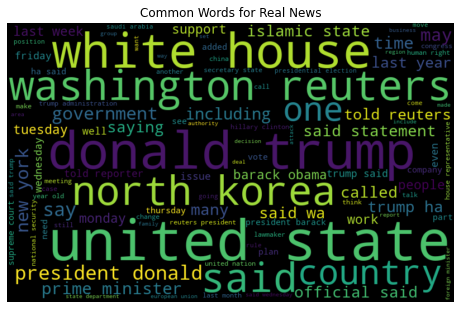

In [82]:
#viz wordcloud on real news
fake_news = df[df['class']==1]
fake_news = ''.join([text for text in fake_news.final_text])
wordcloud = WordCloud(width=800, height=500, max_font_size=100, max_words=100).generate(fake_news)

plt.figure(figsize=(8,6))
plt.title('Common Words for Real News')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Classic Machine Learning

TF-IDF Vectorization

In [ ]:
#Split into X and y
X = df['final_text'].copy()
y = df['class'].copy()

In [ ]:
Tfidf = TfidfVectorizer()
tfidf_vec = Tfidf.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vec, y, test_size = 0.25, stratify = y ,random_state = 25)
def fit_and_eval(model):
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  from sklearn.metrics import classification_report
  print('Report:')
  print(classification_report(y_test, predict))

## Logistic Regression

In [ ]:
lr = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
lr.fit(X_train, y_train)
fit_and_eval(lr)

Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.99      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
fit_and_eval(dt)

Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



## Light GBM Classifier

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
fit_and_eval(lgbm)

Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



## Saving model Classic ML

In [ ]:
import pickle

# saving linear regression model
lr.fit(tfidf_vec, y)
pickle.dump(lr, open("lr.pickle", "wb"))

# saving decision tree model
dt.fit(tfidf_vec, y)
pickle.dump(dt, open("dt.pickle", "wb"))

# saving lgbm model
lgbm.fit(tfidf_vec, y)
pickle.dump(lgbm, open("lgbm.pickle", "wb"))

#saving tf-idf model
pickle.dump(tfidf_vec, open("tfidf_vec.pickle", "wb"))

# Deep Learning

In [66]:
tf.keras.backend.clear_session()

In [61]:
X = df['final_text'].copy()
y = df['class'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y ,random_state = 25)

In [67]:
vocab_size = 50000
max_length = 1000
embed_size = 32
trunc_type = 'post'
oov_tok = "<OOV>"

In [68]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen = max_length, truncating = trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen = max_length)

In [69]:
lstm_units = 256

model_dl = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length = max_length),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dl.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model_dl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          1600000   
                                                                 
 batch_normalization (BatchN  (None, 1000, 32)         128       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 512)        591872    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1000, 512)         0         
                                                                 
 dense (Dense)               (None, 1000, 64)          32832     
                                                                 
 dropout_1 (Dropout)         (None, 1000, 64)          0

In [70]:
history = model_dl.fit(train_pad, 
                    y_train, 
                    epochs=25,
                    batch_size=256, 
                    validation_data=(test_pad, y_test),
                    verbose=1)

Epoch 1/25
132/132 [==============================] - 75s 539ms/step - loss: 0.3666 - accuracy: 0.8105 - val_loss: 0.4369 - val_accuracy: 0.9210
Epoch 2/25
132/132 [==============================] - 70s 529ms/step - loss: 0.0861 - accuracy: 0.9821 - val_loss: 0.4391 - val_accuracy: 0.9196
Epoch 3/25
132/132 [==============================] - 70s 528ms/step - loss: 0.0372 - accuracy: 0.9932 - val_loss: 0.3427 - val_accuracy: 0.9373
Epoch 4/25
132/132 [==============================] - 70s 530ms/step - loss: 0.0169 - accuracy: 0.9972 - val_loss: 0.2860 - val_accuracy: 0.9466
Epoch 5/25
132/132 [==============================] - 70s 528ms/step - loss: 0.4773 - accuracy: 0.6870 - val_loss: 1.7762 - val_accuracy: 0.5320
Epoch 6/25
132/132 [==============================] - 69s 526ms/step - loss: 0.5353 - accuracy: 0.6335 - val_loss: 0.5321 - val_accuracy: 0.6359
Epoch 7/25
132/132 [==============================] - 70s 527ms/step - loss: 0.5301 - accuracy: 0.6354 - val_loss: 0.5333 - val_ac

In [71]:
model_dl.evaluate(test_pad, y_test)

351/351 [==============================] - 14s 41ms/step - loss: 0.0123 - accuracy: 0.9987


[0.0122828409075737, 0.9986523985862732]

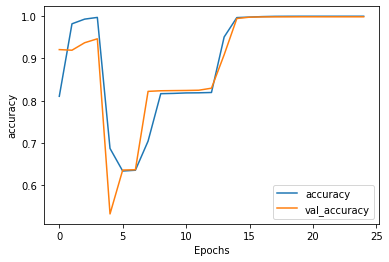

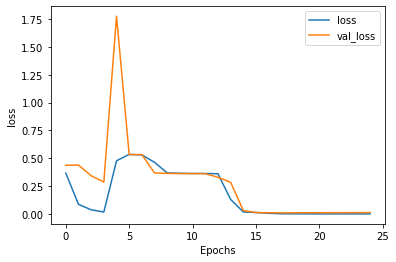

In [72]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [74]:
# Save tokenizer and model deep learning
import pickle
pickle.dump(tokenizer, open("tokenizer.pickle", "wb"))

model_dl.save_weights('model_dl.h5')